In [1]:
#Loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error


In [2]:
#Read data file
train_df = pd.read_csv('final_df.csv')
train_df.drop(columns = 'Unnamed: 0', inplace=True)
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


Getting data ready for Modeling
- (optional) Drop id fields
- One-hot encode all categorical values
- Standardize continous variables
- (optional) Create new features

## One-hot encoding categorical variables

In [3]:
# One-hot encode

# categorical_columns = ['category', 'cuisine', 'city_code', 'region_code', 'center_type', 'op_area']
categorical_columns = ['category', 'cuisine', 'region_code', 'center_type']

# one_hot = pd.get_dummies(train_df['cuisine'], prefix='cuisine', prefix_sep='_', dtype=int)
# train_df = pd.concat([train_df, one_hot], axis=1)
one_hot_columns = [train_df]
for col in categorical_columns:
    one_hot = pd.get_dummies(train_df[col], prefix=col, prefix_sep='_', dtype=int)
    one_hot_columns.append(one_hot)


X_with_categorical = pd.concat(one_hot_columns, axis=1)

X_with_categorical


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,...,0,0,1,0,0,0,0,0,0,1
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,...,0,0,1,0,0,0,0,0,0,1
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,...,0,0,1,0,0,0,0,0,0,1
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,...,0,0,1,0,0,0,0,0,0,1
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,...,0,0,0,0,1,0,0,1,0,0
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,...,0,0,0,0,1,0,0,1,0,0
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,...,0,0,0,0,1,0,0,1,0,0
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,...,0,0,0,0,1,0,0,1,0,0


In [7]:
# ['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
#        'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
#        'cuisine', 'city_code', 'region_code', 'center_type', 'op_area']
numerical_columns = ['week', 'checkout_price', 'base_price']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

x_scaled = scaler.fit_transform(train_df[numerical_columns])
standardized_features = pd.DataFrame(x_scaled, columns=[f"{x}_std" for x in numerical_columns])

X_with_numerical = pd.concat([X_with_categorical, standardized_features], axis=1)
# enhanced_df


# scaler = MinMaxScaler(clip=True)

# x_scaled = scaler.fit_transform(train_df[numerical_columns])
# standardized_features = pd.DataFrame(x_scaled, columns=[f"{x}_std" for x in numerical_columns])

# X_with_numerical = pd.concat([X_with_categorical, standardized_features], axis=1)


X_with_numerical

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C,week_std,checkout_price_std,base_price_std
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,...,0,0,0,0,0,0,1,-1.776494,-1.277687,-1.256048
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,...,0,0,0,0,0,0,1,-1.776494,-1.277687,-1.358465
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,...,0,0,0,0,0,0,1,-1.776494,-1.290568,-1.358278
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,...,0,0,0,0,0,0,1,-1.776494,0.047477,0.518763
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,...,0,0,0,0,0,0,1,-1.776494,-0.580222,-0.694746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,...,0,1,0,0,1,0,0,1.691304,0.992883,0.808467
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,...,0,1,0,0,1,0,0,1.691304,0.979806,0.796023
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,...,0,1,0,0,1,0,0,1.691304,-0.618276,-0.205870
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,...,0,1,0,0,1,0,0,1.691304,-0.580222,-0.253968


['week', 'checkout_price', 'base_price']
week
count    4.565480e+05
mean     1.115583e-16
std      1.000001e+00
min     -1.776494e+00
25%     -8.613810e-01
50%      2.965036e-02
75%      8.725179e-01
max      1.691304e+00
Name: week_std, dtype: float64
checkout_price
count    4.565480e+05
mean     8.231157e-16
std      1.000001e+00
min     -2.152935e+00
25%     -6.753579e-01
50%     -2.315878e-01
75%      7.387956e-01
max      3.491779e+00
Name: checkout_price_std, dtype: float64
base_price
count    4.565480e+05
mean    -7.433690e-16
std      1.000001e+00
min     -1.859224e+00
25%     -6.885239e-01
50%     -2.718877e-01
75%      6.515440e-01
max      3.186454e+00
Name: base_price_std, dtype: float64


<Axes: >

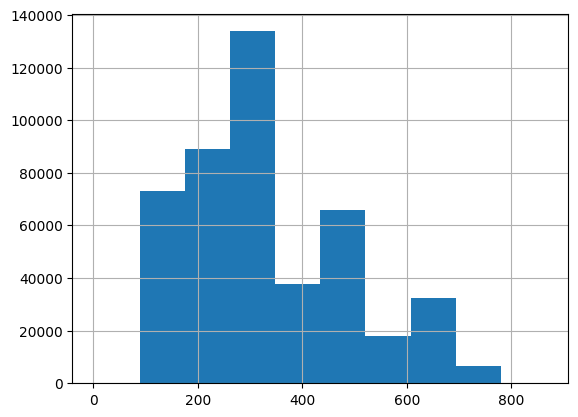

In [11]:
# Checking if outliers in numerical features

print(numerical_columns)

for col in numerical_columns:
    print(col)
    print(X_with_numerical[f'{col}_std'].describe())

X_with_numerical[f'checkout_price'].hist()

#### Drop unwanted columns

In [95]:
drop_columns = ['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area']

X = X_with_numerical.drop(drop_columns, axis=1)
y = X['num_orders']
X = X.drop('num_orders', axis=1)
y

0         177
1         270
2         189
3          54
4          40
         ... 
456543     68
456544     42
456545    501
456546    729
456547    162
Name: num_orders, Length: 456548, dtype: int64

#### Final dataset

In [96]:
X

,emailer_for_promotion,homepage_featured,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,...,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C,week_std,checkout_price_std,base_price_std
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.0,0.155056,0.119543
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.0,0.155056,0.099245
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.0,0.152774,0.099282
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.0,0.389818,0.471292
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.0,0.278617,0.230787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1.0,0.557303,0.528708
456544,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1.0,0.554987,0.526242
456545,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1.0,0.271875,0.327677
456546,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1.0,0.278617,0.318145


Data is ready now!

## Linear Regression Model

In [97]:
# Split the data into training/testing sets
N = X.shape[0]

split_index = int(0.8*N)

X_train = X[:split_index]
X_test = X[split_index:]

# Split the targets into training/testing sets
y_train = y[:split_index]
y_test = y[split_index:]

print("Train size = ", X_train.shape)
print("Test size = ", X_test.shape)
print("Train size = ", y_train.shape)
print("Test size = ", y_test.shape)

Train size =  (365238, 34)
Test size =  (91310, 34)
Train size =  (365238,)
Test size =  (91310,)


In [98]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)


LinearRegression()

In [99]:

# Make predictions using the testing set
y_pred = regr.predict(X_test)


In [100]:
for a,b in zip(y_pred, y_test):
    # print(item)
    if (a<0):
        print(a,b)

y_pred = [max(i, 0) for i in y_pred]

-26.0 14
-96.0 69
-49.5 54
-49.5 40
-10.0 13
-12.5 27
-67.5 55
-2.0 28
-59.0 95
-58.5 55
-70.0 13
-23.0 27
-70.5 14
-141.5 14
-36.0 69
-36.5 53
-60.0 42
-118.5 82
-120.0 42
-118.0 26
-33.5 13
-73.0 53
-75.0 107
-92.5 27
-79.0 69
-78.0 13
-14.0 53
-14.0 148
-14.5 53
-112.5 28
-216.0 15
-125.5 28
-80.0 27
-80.5 54
-80.5 107
-206.5 13
-206.5 15
-19.0 42
-121.0 26
-66.5 55
-73.5 95
-0.5 149
-0.5 134
-2.5 177
-35.0 15
-84.5 54
-139.0 42
-49.5 26
-49.5 40
-72.0 67
-3.5 109
-3.0 150
-3.5 175
-130.0 54
-130.0 27
-129.5 14
-44.5 53
-63.0 41
-66.5 14
-4.0 13
-4.0 55
-4.0 26
-104.5 15
-152.5 95
-207.0 13
-140.0 13
-71.5 81
-72.5 107
-70.5 81
-198.0 13
-198.0 54
-198.5 15
-11.0 28
-39.5 15
-39.5 53
-112.0 55
-6.5 53
-13.0 14
-67.5 40
-2.0 14
-58.0 15
-58.5 14
-59.5 41
-26.5 82
-138.0 41
-63.5 121
-64.0 68
-5.0 13
-4.0 42
-153.0 13
-71.0 107
-70.5 28
-72.5 69
-197.5 14
-113.5 40
-72.0 162
-68.0 123
-26.5 68
-149.0 26
-4.5 27
-4.0 136
-153.0 13
-208.0 13
-117.0 14
-116.5 15
-71.5 149
-71.0 123
-71.0

In [101]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
# print("MSLE: %.2f" % mean_squared_log_error(y_test, y_pred))


Coefficients: 
 [ 2.51697738e+02  2.48913975e+02 -1.72516907e+15 -1.72516907e+15
 -1.72516907e+15 -1.72516907e+15 -1.72516907e+15 -1.72516907e+15
 -1.72516907e+15 -1.72516907e+15 -1.72516907e+15 -1.72516907e+15
 -1.72516907e+15 -1.72516907e+15 -1.72516907e+15 -1.72516907e+15
 -6.68094625e+13 -6.68094625e+13 -6.68094625e+13 -6.68094625e+13
  3.60000423e+15  3.60000423e+15  3.60000423e+15  3.60000423e+15
  3.60000423e+15  3.60000423e+15  3.60000423e+15  3.60000423e+15
 -4.85845082e+15 -4.85845082e+15 -4.85845082e+15 -1.38201102e+01
 -6.26417317e+02  1.00391230e+02]
Mean squared error: 79244.46
Coefficient of determination: 0.41


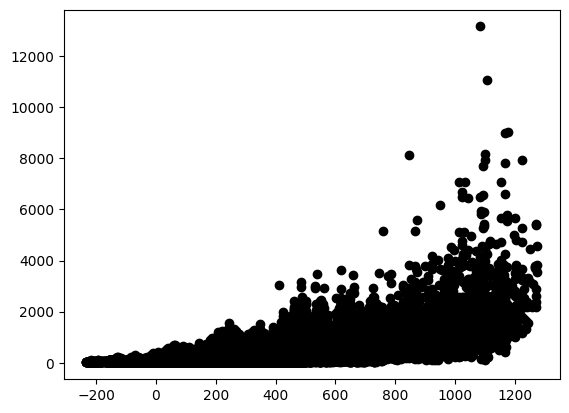

In [104]:
# Plot outputs
plt.scatter(y_pred, y_test, color="black")
# plt.plot(X_test, y_pred, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.show()

In [51]:
# Idea for later
# user is browsing on particular Shop
# predict - final basket value
# user, product, impression/click, basket value

# Regression model
# Shop 1 - selling gloves and socks (5$- 25$)
# Shop 2 - selling branded stuff (200$ - 300$)

# avg_order_value (per_shop)


#  avg_order_value (per_shop) * prediction --> final value

### Debugging section

In [111]:
# Checking if outliers in numerical features

print(numerical_columns)

for col in numerical_columns:
    print(col)
    print(X[f'{col}_std'].describe())

['week', 'checkout_price', 'base_price']
week
count    456548.000000
mean          0.512283
std           0.288368
min           0.000000
25%           0.263889
50%           0.520833
75%           0.763889
max           1.000000
Name: week_std, dtype: float64
checkout_price
count    456548.000000
mean          0.381407
std           0.177157
min           0.000000
25%           0.261763
50%           0.340380
75%           0.512290
max           1.000000
Name: checkout_price_std, dtype: float64
base_price
count    456548.000000
mean          0.368479
std           0.198190
min           0.000000
25%           0.232020
50%           0.314593
75%           0.497608
max           1.000000
Name: base_price_std, dtype: float64
